# Set up



### Versions

In [6]:
!python -V

Python 3.10.19


In [7]:
!pip show numpy

Name: numpy
Version: 2.2.6
Summary: Fundamental package for array computing in Python
Home-page: https://numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: Copyright (c) 2005-2024, NumPy Developers.
         All rights reserved.
         
         Redistribution and use in source and binary forms, with or without
         modification, are permitted provided that the following conditions are
         met:
         
             * Redistributions of source code must retain the above copyright
                notice, this list of conditions and the following disclaimer.
         
             * Redistributions in binary form must reproduce the above
                copyright notice, this list of conditions and the following
                disclaimer in the documentation and/or other materials provided
                with the distribution.
         
             * Neither the name of the NumPy Developers nor the names of any
                contributors may be used to e

In [8]:
!pip show numba

Name: numba
Version: 0.62.1
Summary: compiling Python code using LLVM
Home-page: https://numba.pydata.org
Author: 
Author-email: 
License: BSD
Location: /home/vant/miniforge3/envs/numba/lib/python3.10/site-packages
Requires: llvmlite, numpy
Required-by: 


### Custom Modules

In [ ]:
import time
import random
from tqdm import tqdm

def benchmark_alignment(seqs, mutations, algorithm_func):
    """
    Benchmark alignment algorithm with reads against reference
    
    Args:
        reference_seq: Reference genome sequence
        reads: List of (read_seq, true_position) tuples
        algorithm_func: Alignment function to test
        max_ref_length: Maximum length of reference to search (for performance)
    
    Returns:
        Dictionary with benchmark results
    """
    
    results = {
        'total_reads': len(seqs),
        'total_time': 0,
        'scores': []
    }
        
    print(f"Benchmarking with {len(seqs)} seqs")
    for idx, (seq, mut) in tqdm(enumerate(zip(seqs, mutations)), total=len(seqs), desc="Processing"):     
        start_time = time.time()
        score, ref_aln, read_aln = algorithm_func(list(seq), list(mut))
        elapsed = time.time() - start_time
        
        results['total_time'] += elapsed
        results['scores'].append(score)
        
        print(f"\n--- Seq {idx+1} ---")
        print(f"Score: {score}")
        print(f"Time: {elapsed*1000:.2f} ms")
        print(f"Ref : {ref_aln[:50]}.....")
        print(f"Read: {read_aln[:50]}.....")
                
    
    return results

def generate_reads(genome_seq, num_reads=100, read_length=50, error_rate=0.01):
    """
    Generate simulated sequencing reads from a genome
    
    Args:
        genome_seq: Source genome sequence
        num_reads: Number of reads to generate
        read_length: Length of each read
        error_rate: Probability of sequencing error (substitution)
    
    Returns:
        List of (read_seq, true_position) tuples
    """
    reads = []
    genome_str = str(genome_seq)
    genome_len = len(genome_str)
    
    for i in range(num_reads):
        # Random position in genome
        if genome_len < read_length:
            start_pos = 0
            actual_length = genome_len
        else:
            start_pos = random.randint(0, genome_len - read_length)
            actual_length = read_length
        
        read = list(genome_str[start_pos:start_pos + actual_length])
        
        # Introduce errors
        for j in range(len(read)):
            if random.random() < error_rate:
                # Random substitution
                bases = ['A', 'T', 'G', 'C']
                bases.remove(read[j])
                read[j] = random.choice(bases)
        
        reads.append((''.join(read), start_pos))
    
    return reads

# Load sample data

In [ ]:
import os
from Bio import Entrez, SeqIO
from dotenv import load_dotenv #!pip install python-dotenv


# Load environment variables from .env file
load_dotenv()

ENTREZ_MAIL = os.getenv('ENTREZ_EMAIL')
ECOLI_PATH = "../" + os.getenv('ECOLI_PATH')

# Use them in your code
print(f"Email: {ENTREZ_MAIL[-7:]}")
print(f"E. coli path: {ECOLI_PATH}")

Entrez.email = ENTREZ_MAIL


Email: @ucm.es
E. coli path: ../data/ecoli_k12_mg1655.fasta


In [2]:
print("Downloading E. coli K-12 MG1655 genome...")
ecoli_accession = "U00096.3"  # E. coli K-12 MG1655 complete genome

try:
    # Download from NCBI
    handle = Entrez.efetch(db="nucleotide", id=ecoli_accession, rettype="fasta", retmode="text")
    ecoli_record = SeqIO.read(handle, "fasta")
    handle.close()
    
    # Save to file
    
    SeqIO.write(ecoli_record, ECOLI_PATH, "fasta")
    print(f"✓ Downloaded E. coli genome: {len(ecoli_record.seq)} bp")
    print(f"  Saved to: {ECOLI_PATH}")
    
except Exception as e:
    print(f"Error downloading genome: {e}")
    print("Note: You may need to install biopython: pip install biopython")

Error downloading genome: name 'Entrez' is not defined
Note: You may need to install biopython: pip install biopython


In [5]:
!ls -lh ../{ECOLI_PATH}

ls: no se puede acceder a '../../data/ecoli_k12_mg1655.fasta': No existe el archivo o el directorio


In [11]:
ecoli_record = SeqIO.read(ECOLI_PATH, "fasta")

print("Generating simulated reads...")

# Short reads (Illumina-like) 
# 15–30 nt (nucleotidos) -> Smith–Waterman o búsquedas exactas
short_seqs = generate_reads(ecoli_record.seq, num_reads=20, read_length=50, error_rate=0.01)
print(f"✓ Generated {len(short_seqs)} short seqs (50 nt, 1% error)")

# Medium reads 
# 100–2000 nt  genes / exones -> Needleman–Wunsch (global)
medium_seqs = generate_reads(ecoli_record.seq, num_reads=10, read_length=1000, error_rate=0.02)
print(f"✓ Generated {len(medium_seqs)} medium seqs (100 nt, 2% error)")


# Huge Reads
# 1 kb – 100 kb Contigs / scaffolds -> Algoritmos optimizados (MUMmer, BLAST, BLAT)
huge_seqs = generate_reads(ecoli_record.seq, num_reads=2, read_length=5000, error_rate=0.02)
print(f"✓ Generated {len(huge_seqs)} huge seqs (5kb bp, 2% error)")

Generating simulated reads...
✓ Generated 20 short seqs (50 nt, 1% error)
✓ Generated 10 medium seqs (100 nt, 2% error)
✓ Generated 2 huge seqs (5kb bp, 2% error)


# Benchmarking

| Code      | Works in NumPy? | Works in Numba? | Why                                |
| --------- | --------------- | --------------- | ---------------------------------- |
| `F[i, j]` | ✅               | ✅               | scalar indexing                    |
| `F[I, :]` | ✅               | ✅               | 1-D slice                          |
| `F[I, J]` | ✅               | ❌               | fancy indexing (two array indices) |


In [12]:
import sys
sys.path.append("../")
from src.mutations import mutate_seq
from tests.algorithms_all import needleman_wunsch, needleman_wunsch_diag_numpy, needleman_wunsch_numba, needleman_wunsch_diagbounded_numpy

In [13]:
reads = medium_seqs[:10]
seqs = [ seq for seq, pos in reads]
mutations = [ str(mutate_seq(s, n_mutations=20, seed=8)[0])  for s in seqs]
#print(list(zip(seqs, mutations)))

In [14]:
len(seqs[0])

1000

## Tests

In [19]:
a, b = list("TTGATCA"), list("TTATCA")

In [23]:
needleman_wunsch(a, b)

(np.int64(4), 'TTGATCA', 'TT-ATCA')

In [25]:
needleman_wunsch_numba(a,b)

(np.int64(4), 'TTGATCA', 'TT-ATCA')

In [22]:
needleman_wunsch_diag_numpy(a, b)

(np.int64(4), 'TTGATCA', 'TT-ATCA')

In [24]:
needleman_wunsch_diagbounded_numpy(list("TTGATCA"), list("TTATCA"))

(np.int64(4), 'TTGATCA', 'TT-ATCA')

## Time study

In [101]:
import timeit
from statistics import mean, stdev
import pandas as pd
import matplotlib.pyplot as plt


N_MUTATIONS = 20
SEED = 8
REPEAT = 5
NUMBER = 1

def benchmark_alignment_time(seqs, mutations, algorithm_func):
    for (seq, mut) in zip(seqs, mutations):     
        score, ref_aln, read_aln = algorithm_func(list(seq), list(mut))


import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean, stdev

def visualize_benchmark(times_list, labels, title="Benchmark Results"):
    """
    Create a table and bar plot for benchmark results.

    Parameters:
    - times_list: list of lists, each containing timing results for a method
    - labels: list of strings, names of the methods (must match times_list length)
    - title: string, title for the plot
    """
    if len(times_list) != len(labels):
        raise ValueError("Length of times_list and labels must match.")
    
    # Compute metrics
    means = [mean(times) for times in times_list]
    stds = [stdev(times) for times in times_list]
    
    # Create DataFrame
    df_metrics = pd.DataFrame({
        "Method": labels,
        "Mean Time (s)": means,
        "Std Dev (s)": stds
    })
    
    # Display table
    print(df_metrics)
    
    # Visualization using Matplotlib
    plt.figure(figsize=(8, 5))
    plt.bar(labels, means, yerr=stds, capsize=5, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.ylabel("Time (seconds)")
    plt.show()
    
    return df_metrics

def visualize_benchmark_with_speedup(times_list, labels, baseline_index=0, title="Benchmark Comparison"):
    """
    Create a grid of two plots: original times and speedup relative to baseline.
    
    Parameters:
    - times_list: list of lists, each containing timing results for a method
    - labels: list of strings, names of the methods (must match times_list length)
    - baseline_index: int, index of the baseline method in labels/times_list
    - title: string, title for the figure
    """
    if len(times_list) != len(labels):
        raise ValueError("Length of times_list and labels must match.")
    
    # Compute mean times and std deviations
    means = [mean(times) for times in times_list]
    stds = [stdev(times) for times in times_list]
    
    # Compute speedup
    baseline_time = means[baseline_index]
    speedups = [baseline_time / m for m in means]
    
    # Display table
    df_metrics = pd.DataFrame({
        "Method": labels,
        "Mean Time (s)": means,
        "Std Dev (s)": stds,
        "Speedup": speedups
    })
    
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(14,5))
    
    # Original times (blue)
    axs[0].bar(labels, means, yerr=stds, capsize=5, color='skyblue', edgecolor='black')
    axs[0].set_title("Benchmark Times")
    axs[0].set_ylabel("Time (seconds)")
    
    # Speedup (green)
    axs[1].bar(labels, speedups, color='lightgreen', edgecolor='black')
    axs[1].set_title("Benchmark Speedup")
    axs[1].set_ylabel("Speedup (x)")
    axs[1].axhline(1.0, color='red', linestyle='--', label='Baseline')
    axs[1].legend()
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return df_metrics



### Short seqs

In [87]:
reads = short_seqs
print(len(reads[0][0]))
seqs = [ seq for seq, pos in reads]
mutations = [ str(mutate_seq(s, n_mutations=N_MUTATIONS, seed=SEED)[0])  for s in seqs]

50


In [88]:
times_basic = timeit.repeat(
    lambda: benchmark_alignment_time(mutations, seqs, needleman_wunsch),
    repeat=REPEAT,   # how many independent measurements to make
    number=NUMBER    # how many loops per measurement
)
print("Basic", mean(times_basic))
times_numba = timeit.repeat(
    lambda: benchmark_alignment_time(mutations, seqs, needleman_wunsch_numba),
    repeat=REPEAT,   # how many independent measurements to make
    number=NUMBER    # how many loops per measurement
)
print("Numba", mean(times_numba))

times_diagnonal = timeit.repeat(
    lambda: benchmark_alignment_time(mutations, seqs, needleman_wunsch_diag_numpy),
    repeat=REPEAT,   # how many independent measurements to make
    number=NUMBER    # how many loops per measurement
)
print("Diagonal", mean(times_diagnonal))

times_diagnonal_bounded = timeit.repeat(
    lambda: benchmark_alignment_time(mutations, seqs, needleman_wunsch_diagbounded_numpy),
    repeat=REPEAT,   # how many independent measurements to make
    number=NUMBER    # how many loops per measurement
)
print("Diagonal Bounded", mean(times_diagnonal_bounded))

Basic 0.463533464000102
Numba 0.014590909199978342
Diagonal 0.08066013179977745
Diagonal Bounded 0.09606556540002202


              Method  Mean Time (s)  Std Dev (s)    Speedup
0              Basic       0.463533     0.090172   1.000000
1              Numba       0.014591     0.000927  31.768648
2           Diagonal       0.080660     0.006588   5.746748
3  Diagnonal Bounded       0.096066     0.015713   4.825178


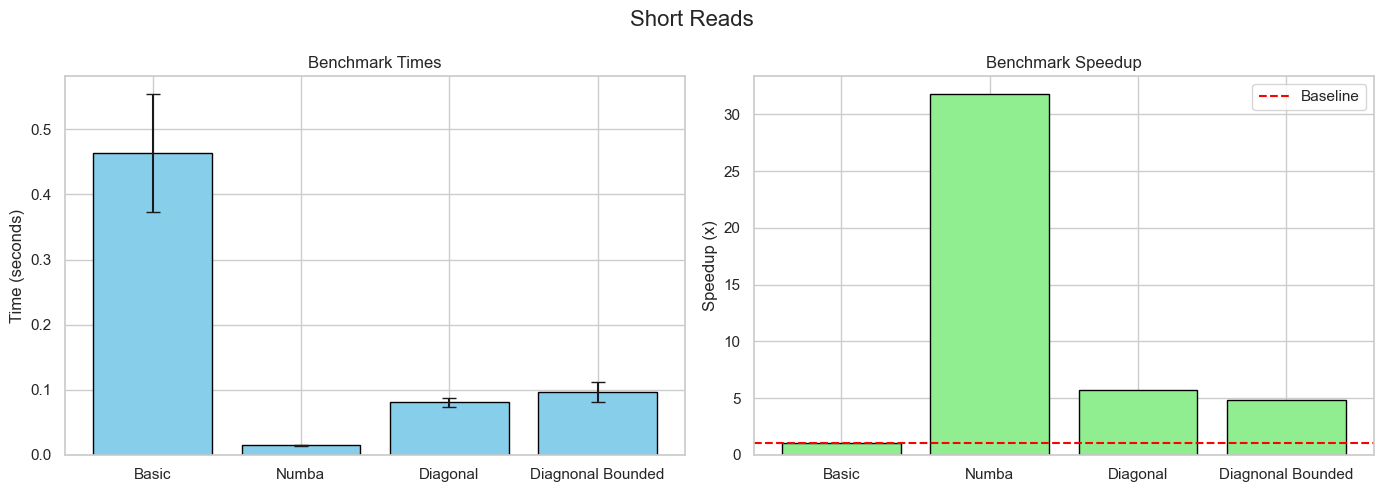

In [89]:
df_metrics_short = visualize_benchmark_with_speedup(
    times_list=[times_basic, times_numba, times_diagnonal, times_diagnonal_bounded],
    labels=["Basic", "Numba", "Diagonal", "Diagnonal Bounded"],
    title="Short Reads"
)

### Medium Seqs

In [92]:
reads = medium_seqs
print(len(reads[0][0]))
seqs = [ seq for seq, pos in reads]
mutations = [ str(mutate_seq(s, n_mutations=N_MUTATIONS, seed=SEED)[0])  for s in seqs]

1000


In [ ]:
times_basic = timeit.repeat(
    lambda: benchmark_alignment_time(mutations, seqs, needleman_wunsch),
    repeat=REPEAT,   # how many independent measurements to make
    number=NUMBER    # how many loops per measurement
)
print("Basic", mean(times_basic))

Basic 73.04729912099992
Numba 1.2432868301999407
Diagonal 1.6200609403998896
Diagonal Bounded 1.9005402946002505


In [96]:
times_numba = timeit.repeat(
    lambda: benchmark_alignment_time(mutations, seqs, needleman_wunsch_numba),
    repeat=REPEAT,   # how many independent measurements to make
    number=NUMBER    # how many loops per measurement
)
print("Numba", mean(times_numba))

times_diagnonal = timeit.repeat(
    lambda: benchmark_alignment_time(mutations, seqs, needleman_wunsch_diag_numpy),
    repeat=REPEAT,   # how many independent measurements to make
    number=NUMBER    # how many loops per measurement
)
print("Diagonal", mean(times_diagnonal))

times_diagnonal_bounded = timeit.repeat(
    lambda: benchmark_alignment_time(mutations, seqs, needleman_wunsch_diagbounded_numpy),
    repeat=REPEAT,   # how many independent measurements to make
    number=NUMBER    # how many loops per measurement
)
print("Diagonal Bounded", mean(times_diagnonal_bounded))

Numba 1.350642857400453
Diagonal 1.7067041038000752
Diagonal Bounded 1.5557983848000732


              Method  Mean Time (s)  Std Dev (s)    Speedup
0              Basic      73.047299     5.300487   1.000000
1              Numba       1.350643     0.134475  54.083356
2           Diagonal       1.706704     0.175740  42.800213
3  Diagnonal Bounded       1.555798     0.096116  46.951649


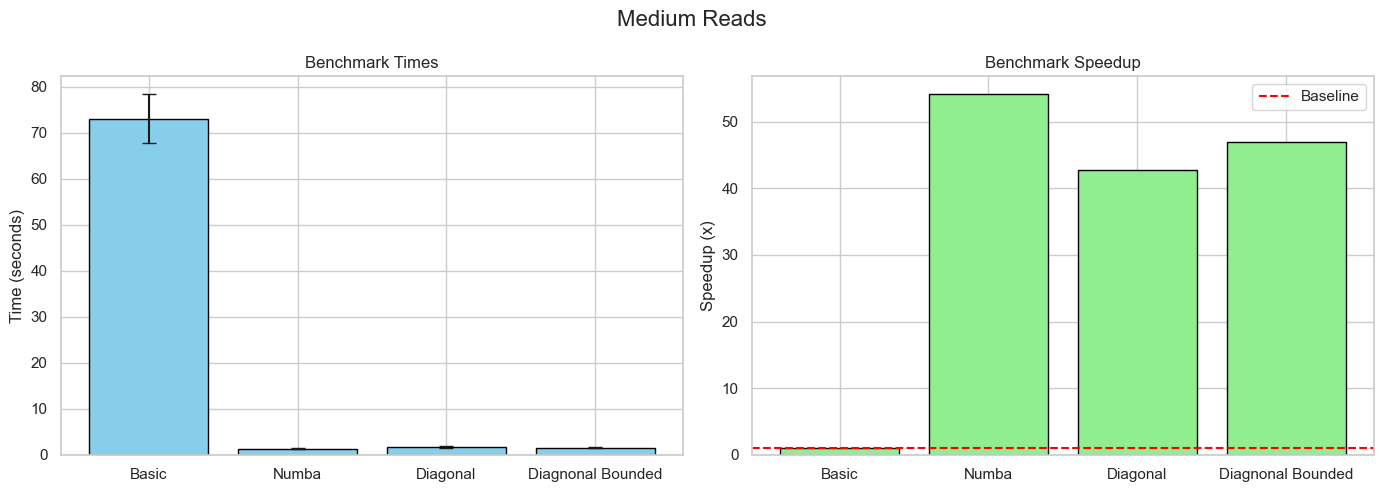

In [97]:
df_metrics_med = visualize_benchmark_with_speedup(
    times_list=[times_basic, times_numba, times_diagnonal, times_diagnonal_bounded],
    labels=["Basic", "Numba", "Diagonal", "Diagnonal Bounded"],
    title="Medium Reads"
)

### Huge

In [98]:
reads = huge_seqs
print(len(reads[0][0]))
seqs = [ seq for seq, pos in reads]
mutations = [ str(mutate_seq(s, n_mutations=N_MUTATIONS, seed=SEED)[0])  for s in seqs]

5000


In [99]:
times_basic = timeit.repeat(
    lambda: benchmark_alignment_time(mutations, seqs, needleman_wunsch),
    repeat=REPEAT,   # how many independent measurements to make
    number=NUMBER    # how many loops per measurement
)
print("Basic", mean(times_basic))

Basic 407.54751668680035


In [102]:
times_numba = timeit.repeat(
    lambda: benchmark_alignment_time(mutations, seqs, needleman_wunsch_numba),
    repeat=REPEAT,   # how many independent measurements to make
    number=NUMBER    # how many loops per measurement
)
print("Numba", mean(times_numba))

times_diagnonal = timeit.repeat(
    lambda: benchmark_alignment_time(mutations, seqs, needleman_wunsch_diag_numpy),
    repeat=REPEAT,   # how many independent measurements to make
    number=NUMBER    # how many loops per measurement
)
print("Diagonal", mean(times_diagnonal))

times_diagnonal_bounded = timeit.repeat(
    lambda: benchmark_alignment_time(mutations, seqs, needleman_wunsch_diagbounded_numpy),
    repeat=REPEAT,   # how many independent measurements to make
    number=NUMBER    # how many loops per measurement
)
print("Diagonal Bounded", mean(times_diagnonal_bounded))

Numba 6.876312988800055
Diagonal 4.914638854000077
Diagonal Bounded 4.027921402399443


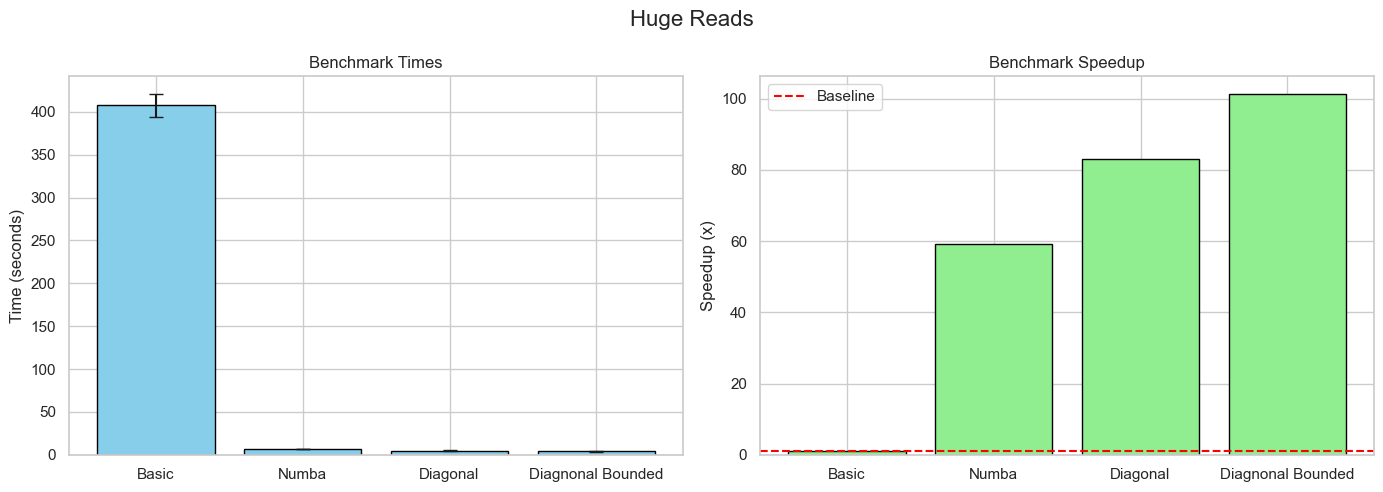

In [103]:
df_metrics_hg = visualize_benchmark_with_speedup(
    times_list=[times_basic, times_numba, times_diagnonal, times_diagnonal_bounded],
    labels=["Basic", "Numba", "Diagonal", "Diagnonal Bounded"],
    title="Huge Reads"
)

In [104]:
df_metrics_hg

,Method,Mean Time (s),Std Dev (s),Speedup
0,Basic,407.547517,12.925709,1.000000
1,Numba,6.876313,0.351401,59.268320
2,Diagonal,4.914639,0.203915,82.925222
3,Diagnonal Bounded,4.027921,0.409247,101.180603


### Vis

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Datos extraídos de la tabla (usamos solo la columna Speedup)
data = {
    "Algorithm": [
      #  "Basic", "Basic", "Basic",
        "Diag", "Diag", "Diag",
        "Diag B.", "Diag B.", "Diag B.",
        "Numba", "Numba", "Numba",
    ],
    "Benchmark": [
      #  "Short", "Medium", "Huge",
        "Short", "Medium", "Huge",
        "Short", "Medium", "Huge",
        "Short", "Medium", "Huge",
    ],
    "Speedup": [
      #  1.00, 1.00, 1.00,        # Basic
        5.75, 42.80, 82.92,     # Diag
        4.83, 46.95, 101.18,    # Diag B.
        31.77, 54.08, 59.26     # Numba
    ]
}

df = pd.DataFrame(data)
df.head()

,Algorithm,Benchmark,Speedup
0,Diag,Short,5.75
1,Diag,Medium,42.80
2,Diag,Huge,82.92
3,Diag B.,Short,4.83
4,Diag B.,Medium,46.95


/tmp/ipykernel_7375/156715285.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x="Benchmark", y="Speedup", hue="Algorithm",


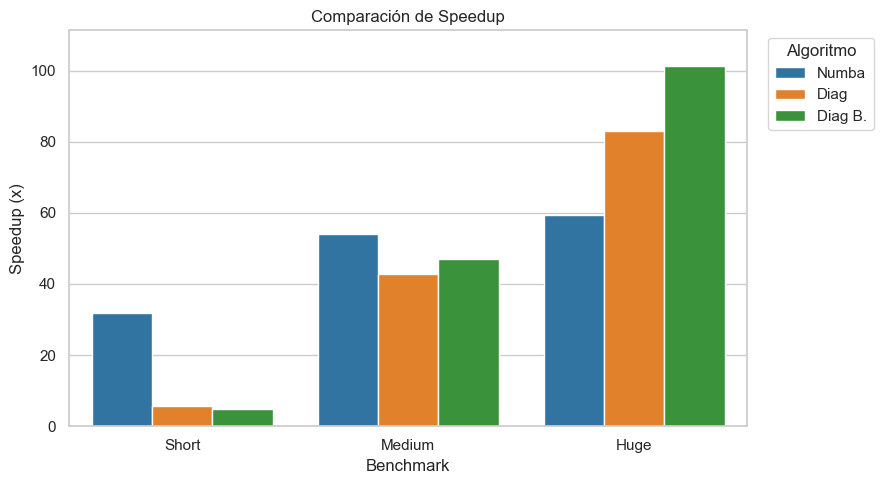

In [11]:
bench_order = ["Short", "Medium", "Huge"]
alg_order = ["Numba", "Diag", "Diag B."]


# 1) Grouped bar chart (más claro para comparar speedups por benchmark)
plt.figure(figsize=(9,5))
sns.barplot(data=df, x="Benchmark", y="Speedup", hue="Algorithm",
            order=bench_order, hue_order=alg_order, ci=None, palette="tab10")
plt.yscale("linear")
plt.ylabel("Speedup (x)")
plt.title("Comparación de Speedup")
plt.ylim(0, df["Speedup"].max() * 1.1)
plt.legend(title="Algoritmo", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

## More detail benchmarking

In [32]:
results = benchmark_alignment(
    mutations,
    seqs, 
    needleman_wunsch
)

print(f"Total time: {results['total_time']*1000:.2f} ms")

Benchmarking with 10 seqs


Processing:  10%|█         | 1/10 [00:02<00:18,  2.08s/it]


--- Seq 1 ---
Score: 954
Time: 2078.81 ms
Ref : GATGCGGTGCTGCGCACCTTATTTGGCCTAAGAAATCATTCAAATTCCAT.....
Read: GATGCGGTGCTGCGCACCTTATTTGGCCTAAGAAATCATTCAAATTCCAT.....


Processing:  20%|██        | 2/10 [00:03<00:15,  1.96s/it]


--- Seq 2 ---
Score: 954
Time: 1872.82 ms
Ref : GCAGCGGAGTGACATGTTTATGAACAATCGCCATTTTGATATGACGCGCT.....
Read: GCAGCGGAGTGACATGTTTATGAACAATCGCCATTTTGATATGACGCGCT.....


Processing:  30%|███       | 3/10 [00:06<00:14,  2.09s/it]


--- Seq 3 ---
Score: 954
Time: 2242.72 ms
Ref : GCCCGACGGTATGGTCAATATCATTGGCGTGGGCAGCTGCCCGTCGCGTG.....
Read: GCCCGACGGTATGGTCAATATCATTGGCGTGGGCAGCTGCCCGTCGCGTG.....


Processing:  40%|████      | 4/10 [00:08<00:12,  2.03s/it]


--- Seq 4 ---
Score: 954
Time: 1945.10 ms
Ref : CATTTTCACCTAACGATTCACCGTGGTCAGAAAGATAAACCAGGCTGGTG.....
Read: CATTTTCACCTAACGATTCACCGTGGTCAGAAAGATAAACCAGGCTGGTG.....


Processing:  50%|█████     | 5/10 [00:10<00:10,  2.03s/it]


--- Seq 5 ---
Score: 954
Time: 2032.41 ms
Ref : ATCCAGCGCGTCCATCGTCATTAGCAGTAACACCACGGCCAACAGGCTGA.....
Read: ATCCAGCGCGTCCATCGTCATTAGCAGTAACACCACGGCCAACAGGCTGA.....


Processing:  60%|██████    | 6/10 [00:11<00:07,  1.94s/it]


--- Seq 6 ---
Score: 954
Time: 1750.81 ms
Ref : AACGCGAGCGACAGTAAATTAGGTGCGAAAAAAAACCTGCGTATCCGCGC.....
Read: AACGCGAGCGACAGTAAATTAGGTGCGAAAAAAAACCTGCGTATCCGCGC.....


Processing:  70%|███████   | 7/10 [00:13<00:05,  1.92s/it]


--- Seq 7 ---
Score: 954
Time: 1888.66 ms
Ref : AGGTGGCGAGGCCAGGGCTGCGTATGGTGCGCAGCTAATCAAGCGACTAT.....
Read: AGGTGGCGAGGCCAGGGCTGCGTATGGTGCGCAGCTAATCAAGCGACTAT.....


Processing:  80%|████████  | 8/10 [00:15<00:03,  1.92s/it]


--- Seq 8 ---
Score: 954
Time: 1910.19 ms
Ref : AACGGTGGGCTATGAGTTGATGTGCGCGCTGGCGCTACGCGTCCCGGTTG.....
Read: AACGGTGGGCTATGAGTTGATGTGCGCGCTGGCGCTACGCGTCCCGGTTG.....


Processing:  90%|█████████ | 9/10 [00:17<00:01,  1.96s/it]


--- Seq 9 ---
Score: 954
Time: 2040.63 ms
Ref : GATTTTTTCCGCGCGATGTCCTTCCAGTACACGCAGGTTACCGCCATTTT.....
Read: GATTTTTTCCGCGCGATGTCCTTCCAGTACACGCAGGTTACCGCCATTTT.....


Processing: 100%|██████████| 10/10 [00:20<00:00,  2.03s/it]


--- Seq 10 ---
Score: 954
Time: 2473.54 ms
Ref : CACGCCGGGATCAGGCACCCTACCATGCCGCAAATCGGGCTACAGATAGA.....
Read: CACGCCGGGATCAGGCACCCTACCATGCCGCAAATCGGGCTACAGATAGA.....
Total time: 20235.69 ms


In [ ]:
results = benchmark_alignment(
    mutations,
    seqs, 
    needleman_wunsch_numba
)

print(f"Total time: {results['total_time']*1000:.2f} ms")
print(f"Average alignment score: {mean(results['scores']):.2f}")

Benchmarking with 10 seqs


Processing:  20%|██        | 2/10 [00:00<00:01,  7.76it/s]


--- Seq 1 ---
Score: 954
Time: 145.02 ms
Ref : GATGCGGTGCTGCGCACCTTATTTGGCCTAAGAAATCATTCAAATTCCAT.....
Read: GATGCGGTGCTGCGCACCTTATTTGGCCTAAGAAATCATTCAAATTCCAT.....

--- Seq 2 ---
Score: 954
Time: 116.01 ms
Ref : GCAGCGGAGTGACATGTTTATGAACAATCGCCATTTTGATATGACGCGCT.....
Read: GCAGCGGAGTGACATGTTTATGAACAATCGCCATTTTGATATGACGCGCT.....


Processing:  30%|███       | 3/10 [00:00<00:00,  8.07it/s]


--- Seq 3 ---
Score: 954
Time: 116.80 ms
Ref : GCCCGACGGTATGGTCAATATCATTGGCGTGGGCAGCTGCCCGTCGCGTG.....
Read: GCCCGACGGTATGGTCAATATCATTGGCGTGGGCAGCTGCCCGTCGCGTG.....


Processing:  40%|████      | 4/10 [00:00<00:00,  7.56it/s]


--- Seq 4 ---
Score: 954
Time: 143.40 ms
Ref : CATTTTCACCTAACGATTCACCGTGGTCAGAAAGATAAACCAGGCTGGTG.....
Read: CATTTTCACCTAACGATTCACCGTGGTCAGAAAGATAAACCAGGCTGGTG.....


Processing:  50%|█████     | 5/10 [00:00<00:00,  7.02it/s]


--- Seq 5 ---
Score: 954
Time: 158.68 ms
Ref : ATCCAGCGCGTCCATCGTCATTAGCAGTAACACCACGGCCAACAGGCTGA.....
Read: ATCCAGCGCGTCCATCGTCATTAGCAGTAACACCACGGCCAACAGGCTGA.....


Processing:  60%|██████    | 6/10 [00:00<00:00,  6.61it/s]


--- Seq 6 ---
Score: 954
Time: 166.02 ms
Ref : AACGCGAGCGACAGTAAATTAGGTGCGAAAAAAAACCTGCGTATCCGCGC.....
Read: AACGCGAGCGACAGTAAATTAGGTGCGAAAAAAAACCTGCGTATCCGCGC.....


Processing:  80%|████████  | 8/10 [00:01<00:00,  6.56it/s]


--- Seq 7 ---
Score: 954
Time: 152.95 ms
Ref : AGGTGGCGAGGCCAGGGCTGCGTATGGTGCGCAGCTAATCAAGCGACTAT.....
Read: AGGTGGCGAGGCCAGGGCTGCGTATGGTGCGCAGCTAATCAAGCGACTAT.....

--- Seq 8 ---
Score: 954
Time: 150.68 ms
Ref : AACGGTGGGCTATGAGTTGATGTGCGCGCTGGCGCTACGCGTCCCGGTTG.....
Read: AACGGTGGGCTATGAGTTGATGTGCGCGCTGGCGCTACGCGTCCCGGTTG.....


Processing:  90%|█████████ | 9/10 [00:01<00:00,  6.60it/s]


--- Seq 9 ---
Score: 954
Time: 145.88 ms
Ref : GATTTTTTCCGCGCGATGTCCTTCCAGTACACGCAGGTTACCGCCATTTT.....
Read: GATTTTTTCCGCGCGATGTCCTTCCAGTACACGCAGGTTACCGCCATTTT.....


Processing: 100%|██████████| 10/10 [00:01<00:00,  6.91it/s]


--- Seq 10 ---
Score: 954
Time: 131.45 ms
Ref : CACGCCGGGATCAGGCACCCTACCATGCCGCAAATCGGGCTACAGATAGA.....
Read: CACGCCGGGATCAGGCACCCTACCATGCCGCAAATCGGGCTACAGATAGA.....
Total time: 1426.89 ms
Average alignment score: 954.00


In [18]:
results = benchmark_alignment(
    mutations,
    seqs, 
    needleman_optimized
)

print(f"Total time: {results['total_time']*1000:.2f} ms")
print(f"Average alignment score: {mean(results['scores']):.2f}")

Benchmarking with 10 seqs


Processing:  20%|██        | 2/10 [00:00<00:01,  5.27it/s]


--- Seq 1 ---
Score: 954
Time: 222.03 ms
Ref : GATGCGGTGCTGCGCACCTTATTTGGCCTAAGAAATCATTCAAATTCCAT.....
Read: GATGCGGTGCTGCGCACCTTATTTGGCCTAAGAAATCATTCAAATTCCAT.....

--- Seq 2 ---
Score: 954
Time: 165.17 ms
Ref : GCAGCGGAGTGACATGTTTATGAACAATCGCCATTTTGATATGACGCGCT.....
Read: GCAGCGGAGTGACATGTTTATGAACAATCGCCATTTTGATATGACGCGCT.....


Processing:  40%|████      | 4/10 [00:00<00:01,  4.68it/s]


--- Seq 3 ---
Score: 954
Time: 298.41 ms
Ref : GCCCGACGGTATGGTCAATATCATTGGCGTGGGCAGCTGCCCGTCGCGTG.....
Read: GCCCGACGGTATGGTCAATATCATTGGCGTGGGCAGCTGCCCGTCGCGTG.....

--- Seq 4 ---
Score: 954
Time: 172.87 ms
Ref : CATTTTCACCTAACGATTCACCGTGGTCAGAAAGATAAACCAGGCTGGTG.....
Read: CATTTTCACCTAACGATTCACCGTGGTCAGAAAGATAAACCAGGCTGGTG.....


Processing:  60%|██████    | 6/10 [00:01<00:00,  5.31it/s]


--- Seq 5 ---
Score: 954
Time: 171.02 ms
Ref : ATCCAGCGCGTCCATCGTCATTAGCAGTAACACCACGGCCAACAGGCTGA.....
Read: ATCCAGCGCGTCCATCGTCATTAGCAGTAACACCACGGCCAACAGGCTGA.....

--- Seq 6 ---
Score: 954
Time: 166.44 ms
Ref : AACGCGAGCGACAGTAAATTAGGTGCGAAAAAAAACCTGCGTATCCGCGC.....
Read: AACGCGAGCGACAGTAAATTAGGTGCGAAAAAAAACCTGCGTATCCGCGC.....


Processing:  80%|████████  | 8/10 [00:01<00:00,  5.68it/s]


--- Seq 7 ---
Score: 954
Time: 165.39 ms
Ref : AGGTGGCGAGGCCAGGGCTGCGTATGGTGCGCAGCTAATCAAGCGACTAT.....
Read: AGGTGGCGAGGCCAGGGCTGCGTATGGTGCGCAGCTAATCAAGCGACTAT.....

--- Seq 8 ---
Score: 954
Time: 163.76 ms
Ref : AACGGTGGGCTATGAGTTGATGTGCGCGCTGGCGCTACGCGTCCCGGTTG.....
Read: AACGGTGGGCTATGAGTTGATGTGCGCGCTGGCGCTACGCGTCCCGGTTG.....


Processing: 100%|██████████| 10/10 [00:01<00:00,  5.34it/s]


--- Seq 9 ---
Score: 954
Time: 169.80 ms
Ref : GATTTTTTCCGCGCGATGTCCTTCCAGTACACGCAGGTTACCGCCATTTT.....
Read: GATTTTTTCCGCGCGATGTCCTTCCAGTACACGCAGGTTACCGCCATTTT.....

--- Seq 10 ---
Score: 954
Time: 166.14 ms
Ref : CACGCCGGGATCAGGCACCCTACCATGCCGCAAATCGGGCTACAGATAGA.....
Read: CACGCCGGGATCAGGCACCCTACCATGCCGCAAATCGGGCTACAGATAGA.....
Total time: 1861.03 ms
Average alignment score: 954.00
